In [2]:
# making A Generative Adverserial Network(GAN's) for the first time to generate dog images

from torchvision.datasets import ImageFolder,FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torchvision.utils import make_grid
from torchvision import transforms
import os
import numpy as np

from tqdm import tqdm 
import matplotlib.pyplot as plt
import torchvision.utils as vutils

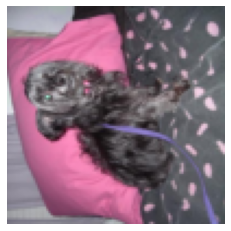

In [3]:
## My folder structure was 
'''
petimages//Cat -- Dog ,
MUST READ --

since,
I wanted only dogs as my Entry in The Gan to generate imgs of dogs🐶🐶🐶

Image folder gives an error if you directly reads a folder with images 

instead it demands a folder of images 

so i changed my structure to --- 
petsimages// Cats -- img
I moved the Dog folder to img 
'''
folder = ImageFolder(root='../starters/PetImages/img',transform=transforms.Compose([
    transforms.Resize((100,100)),
        transforms.RandomHorizontalFlip(0.8),
    transforms.ToTensor()]))

train_loader = DataLoader(folder,batch_size=32)
images,labels = next(iter(train_loader))

plt.imshow(images[0].squeeze().permute(2,1,0))
plt.axis('off')
plt.show()

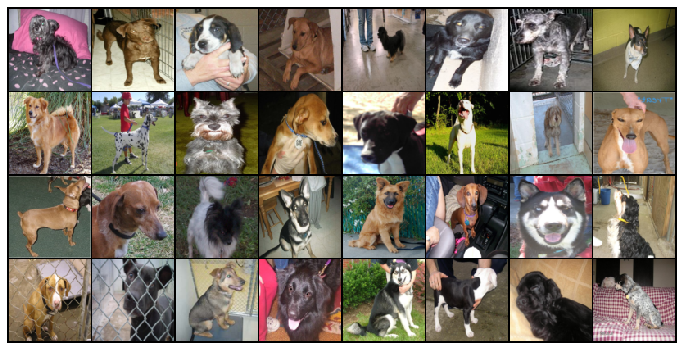

In [4]:
def show(img):
    plt.figure(figsize=(12,10))
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

grid = make_grid(images, nrow=8)
show(grid)

Making a Generator which takes in a noise vector and makes it into a image vector 

which gets feeded to our Discriminator class 

In [7]:
class generator(nn.Module):
    def __init__(self,noise=10,imagedim=10000,hiddendim=100):
        super(generator,self).__init__()
        self.genlayers = nn.Sequential(
                        nn.Linear(noise,hiddendim),
            nn.BatchNorm1d(hiddendim),
            nn.LeakyReLU(0.3),
            nn.Linear(hiddendim,hiddendim*5),
            nn.BatchNorm1d(hiddendim*5),
            nn.LeakyReLU(0.3),
            nn.Linear(hiddendim*5,hiddendim*10),
            nn.LeakyReLU(0.3),
            nn.Linear(hiddendim*10,imagedim),
            nn.LeakyReLU()
                    )
    def forward(self,z):
        return self.genlayers(z)
         

class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=10000, hidden_dim=96):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(10000,1000),
            nn.LeakyReLU(0.3),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(1000,1),
            nn.Sigmoid()
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc


In [21]:
batch_size=32
z_dim = 64
gen = generator(z_dim)
disc = Discriminator()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(gen))

g_opt = torch.optim.SGD(list(gen.parameters()),lr=3e-4)
d_opt = torch.optim.Adam(list(disc.parameters()),lr=3e-4)

criterion = nn.BCELoss()


## earlier the model sizze was somewhere 41 million parameters and disc had 3.9 billion 😂😂
# just because the images were 250*250 and the number of layers were wayyyy more than required

epochs = 1
gen.to(device)
disc.to(device)

10569200


Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=10000, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=1000, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [15]:
Loss_g = []
Loss_d = []

# RUNNING THIS THING GAVE ME AN ERROR SO I CHANGE THE DISCRIMINATOR OR USE TESTING TO CHECK FOR ERRORS

for i in tqdm(range(epochs)):
    for j,(images,_) in tqdm(enumerate(train_loader)):
        realimage = images.to(device)
        realimage = realimage.view(-1,10000).to(device)
        fake_label = torch.ones(realimage.shape[0])
        disc_out_real = disc(realimage).view(96)
        err_dreal = criterion(disc_out_real,fake_label)
        # Training the discriminator with a fake image generated by the generator
        noise = torch.randn(realimage.shape[0],z_dim)
        fake_img = gen(noise)
        fake_label = torch.zeros(realimage.size()[0])
        disc_out_fake = disc(fake_img.detach()).view(-1)#I think we detach to retain the gradient correct me if i am wrong
        err_dfake = criterion(disc_out_fake,fake_label)
        # now backpropagating error
        errD = err_dreal + err_dfake
        errD.backward()
        d_opt.step()
        
        ## TRaining Generator
        gen.zero_grad()
        target = torch.ones(realimage.size()[0])
        output = disc(fake_img).view(-1)
        errG = criterion(output, target)
        errG.backward()
        g_opt.step()
        Loss_g.append(errG)
        Loss_d.append(errD)
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (i, epochs, j, len(train_loader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(realimage, '%s/real_samples.png' % "./results", normalize=True)
            fake = gen(noise)
            vutils.save_image(fake_img.data, '%s/fake_samples_epoch_%03d.png' % ("./results", i), normalize=True)
            
        if j==20:
            break
            


  0%|                                                             | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]

[0/1][0/388] Loss_D: 1.4822; Loss_G: 0.0965



1it [00:01,  1.25s/it]

[0/1][1/388] Loss_D: 2.4260; Loss_G: 0.0223



2it [00:02,  1.19s/it]

[0/1][2/388] Loss_D: 3.8989; Loss_G: 0.0123



3it [00:03,  1.22s/it]

[0/1][3/388] Loss_D: 4.6053; Loss_G: 0.0104



4it [00:04,  1.24s/it]

[0/1][4/388] Loss_D: 4.7344; Loss_G: 0.0130



5it [00:06,  1.18s/it]

[0/1][5/388] Loss_D: 4.5304; Loss_G: 0.0181



6it [00:07,  1.16s/it]

[0/1][6/388] Loss_D: 4.1384; Loss_G: 0.0312



7it [00:08,  1.12s/it]

[0/1][7/388] Loss_D: 3.5746; Loss_G: 0.0587



8it [00:09,  1.14s/it]

[0/1][8/388] Loss_D: 2.9248; Loss_G: 0.1193



9it [00:10,  1.16s/it]

[0/1][9/388] Loss_D: 2.2139; Loss_G: 0.2528



10it [00:11,  1.16s/it]

[0/1][10/388] Loss_D: 1.5143; Loss_G: 0.5155



11it [00:12,  1.18s/it]

[0/1][11/388] Loss_D: 0.9392; Loss_G: 0.9071



12it [00:14,  1.19s/it]

[0/1][12/388] Loss_D: 0.5246; Loss_G: 1.4772



13it [00:15,  1.20s/it]

[0/1][13/388] Loss_D: 0.2710; Loss_G: 2.1702



14it [00:16,  1.19s/it]

[0/1][14/388] Loss_D: 0.1329; Loss_G: 2.9099



15it [00:17,  1.17s/it]

[0/1][15/388] Loss_D: 0.0618; Loss_G: 3.6609



16it [00:18,  1.16s/it]

[0/1][16/388] Loss_D: 0.0319; Loss_G: 4.2420



17it [00:19,  1.14s/it]

[0/1][17/388] Loss_D: 0.0200; Loss_G: 4.7507



18it [00:21,  1.14s/it]

[0/1][18/388] Loss_D: 0.0209; Loss_G: 5.0604



19it [00:22,  1.15s/it]

[0/1][19/388] Loss_D: 0.0366; Loss_G: 5.2021



20it [00:23,  1.20s/it]

[0/1][20/388] Loss_D: 0.0478; Loss_G: 5.1711


20it [00:24,  1.23s/it]
100%|█████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.59s/it]


In [20]:
torch.save(gen.state_dict(),'GanDog.pth')

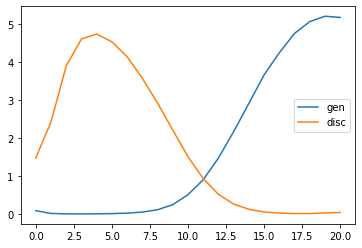

In [22]:
plt.plot(Loss_g,label='gen')
plt.plot(Loss_d,label='disc')
plt.legend()
plt.show()

In [23]:
noise = torch.randn((batch_size,z_dim))

In [37]:
show(make_grid(gen(noise).detach()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [39]:
gen(noise).detach().shape

torch.Size([32, 10000])